In [17]:
!pip install scikit-multilearn
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.text import FreqDistVisualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
pd.set_option('display.max_colwidth', None)

### Entendimiento y preprocesamiento de los datos

In [19]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
def tokenizer(text):
    text = text.replace("\n", " ")
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [ps.stem(t) for t in tokens]
    tokens = [t for t in tokens if len(t) > 2]
    return tokens

In [21]:
data = pd.read_csv('/content/data.csv', sep = ',', error_bad_lines=False,engine='python')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
data.shape

(314562, 2)

In [23]:
data.sample(5)

,text,stars
221095,"Always a little more expensive in the airport! The serving size is smaller too. The employees are nice not much interaction it always fast pace due to long lines.\n\nI ordered salad bowl, no rice, half steak and chicken , cheese and medium sauce. It was keto friendly and delicious!",3
157127,For a bay area resident this was a pretty ordinary indian restaurant. the tandoori was the only good items. the curry and meat inside the curry was stale and taste terrible. naan was burnt. the paneer saag was terrible.,3
299234,"Returned for our 2nd visit today and can happily upgrade to 5 stars. The wait staff has the system down, and they really hustle.\nStarted with Summer rolls with shrimp - they were delivered almost immediately and tided us over until our entrees arrived - they are very flavorful and have a nice crunch.\nI had the Khao pad puu, which has a surprising amount of heat and is very filling. the rice has a satisfying stickiness to it. This is a very filling dish, I brought home leftovers for another meal.\nMy wife had the Pad prik pow crispy chicken. Winner, winner, chicken dinner. This stuff is wicked good - crackling crispy, sweet-salty. Next time we order this it will be to share.\nTook the free refill on my Thai iced tea this time - it is really wonderful stuff and does a great job cutting the heat.\nThis place is now one of our go-to restaurants in the area, no doubt about it. Looks like business is doing well, get there earlier to avoid a wait.",5
18119,"Fixed a problem with my iPhone that everyone else said ""get a new one"". Saved a thousand dollars. Thanks Dustin.",5
13170,So disappointed in this hotel. Cleaning staff knock on your door at 8am. They will also stop you in the hallway and ask if you want room service and if not to sign their paper. I got one hot shower throughout my week stay and was woken by street trucks at 5:30am daily. The lobby and hotel bar area are very cute - those are my two stars.,2


In [24]:
data['stars'].value_counts()

5    145748
4     64891
1     48453
3     30928
2     24542
Name: stars, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['stars'], test_size = 0.2, stratify = data['stars'], random_state = 1)

In [26]:
X_train.shape

(251649,)

In [27]:
pd.Series(y_train).value_counts(normalize = True)

5    0.463336
4    0.206291
1    0.154032
3    0.098319
2    0.078021
Name: stars, dtype: float64

In [28]:
X_test.shape

(62913,)

In [29]:
pd.Series(y_test).value_counts(normalize = True)

5    0.463338
4    0.206285
1    0.154038
3    0.098326
2    0.078012
Name: stars, dtype: float64

### Función de evaluación

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

def metricsReport(modelName, test_labels, predictions):
    f1 = f1_score(test_labels, predictions, average=None)
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_f1 = f1_score(test_labels, predictions, average='micro')

    avg_f1 = f1_score(test_labels, predictions, average='weighted')
    
    hamLoss = hamming_loss(test_labels, predictions)
    print(f'Modelo {modelName}')
    print(f'F1 Score {f1}')
    print(f'F1 Score weighted {avg_f1}')
    print(f'Micro F1 Score {micro_f1}')
    print(f'Macro F1 Score {macro_f1}')
    print(f'Hamming loss {hamLoss}')

### Bayes

In [31]:
pipelineB = Pipeline([
                ('bow', CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, max_df=0.6)),
                ('clf', OneVsRestClassifier(MultinomialNB())),
            ])
pipelineB.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('bow',
                 CountVectorizer(max_df=0.6,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 tokenizer=<function tokenizer at 0x7fa3db6c1ef0>)),
                ('clf', OneVsRestClassifier(estimator=MultinomialNB()))])

In [32]:
y_train_bow_predict = pipelineB.predict(X_train)
y_test_bow_predict = pipelineB.predict(X_test)

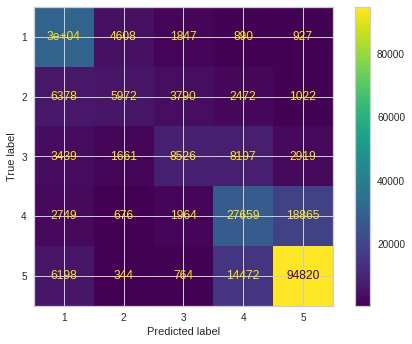

In [33]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)  #Entrenamiento

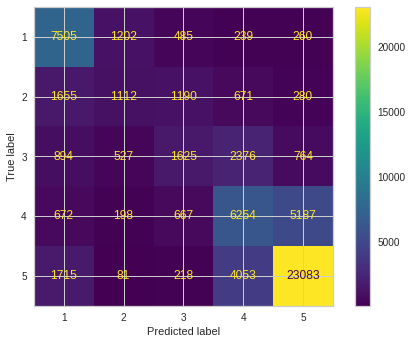

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)  #Test

In [35]:
metricsReport('Bayes', y_test, y_test_bow_predict)

Modelo Bayes
F1 Score [0.67820351 0.27703039 0.31337383 0.47073878 0.78615217]
F1 Score weighted 0.6182545648000387
Micro F1 Score 0.6291068618568499
Macro F1 Score 0.5050997351119055
Hamming loss 0.37089313814315006


### RandomForest

In [36]:
pipelineRF = Pipeline([
                ('bow', CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, max_df=0.6)),
                ('clf', RandomForestClassifier(random_state = 2)),
            ])
pipelineRF.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('bow',
                 CountVectorizer(max_df=0.6,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 tokenizer=<function tokenizer at 0x7fa3db6c1ef0>)),
                ('clf', RandomForestClassifier(random_state=2))])

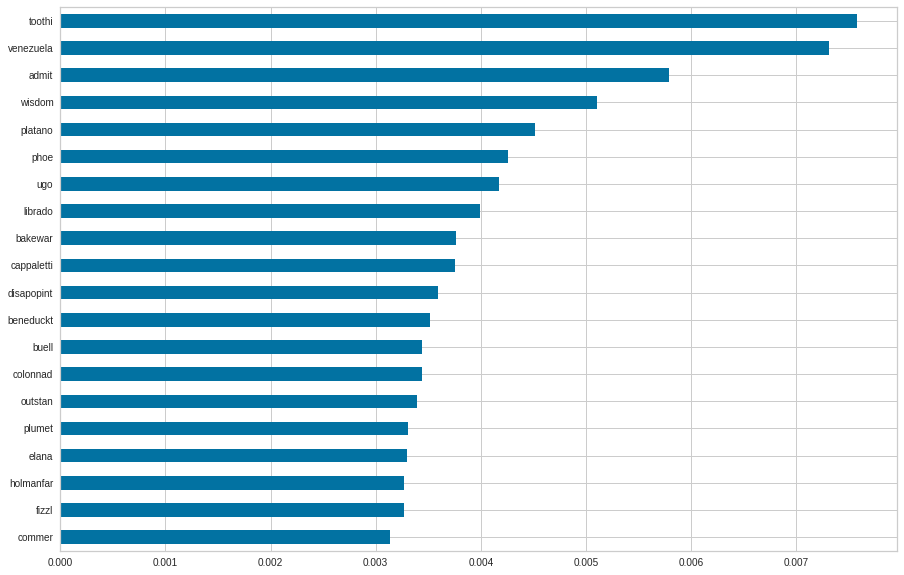

In [37]:
pd.Series(pipelineRF['clf'].feature_importances_, index = pipelineRF['bow'].vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [38]:
bow_estimators = pipelineRF['clf'].estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 658.22


In [39]:
y_train_bow_predict = pipelineRF.predict(X_train)
y_test_bow_predict = pipelineRF.predict(X_test)

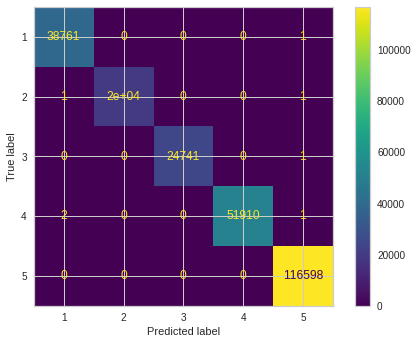

In [40]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict) #Entrenamiento

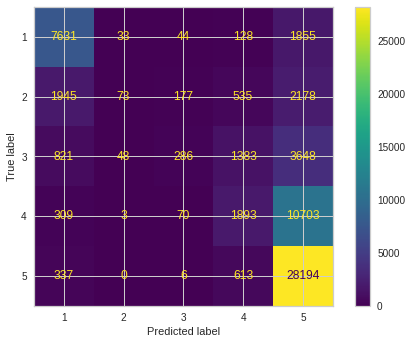

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict) #Test

In [42]:
metricsReport('RandomForest', y_test, y_test_bow_predict)

Modelo RandomForest
F1 Score [0.73608566 0.02882527 0.08450288 0.21597262 0.7446123 ]
F1 Score weighted 0.5135020812457137
Micro F1 Score 0.6052326228283502
Macro F1 Score 0.3619997447339573
Hamming loss 0.3947673771716497


### Arbol de decisión

In [43]:
pipelineDT = Pipeline([
                ('bow', CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, max_df=0.6)),
                ('clf', DecisionTreeClassifier()),
            ])
pipelineDT.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('bow',
                 CountVectorizer(max_df=0.6,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 tokenizer=<function tokenizer at 0x7fa3db6c1ef0>)),
                ('clf', DecisionTreeClassifier())])

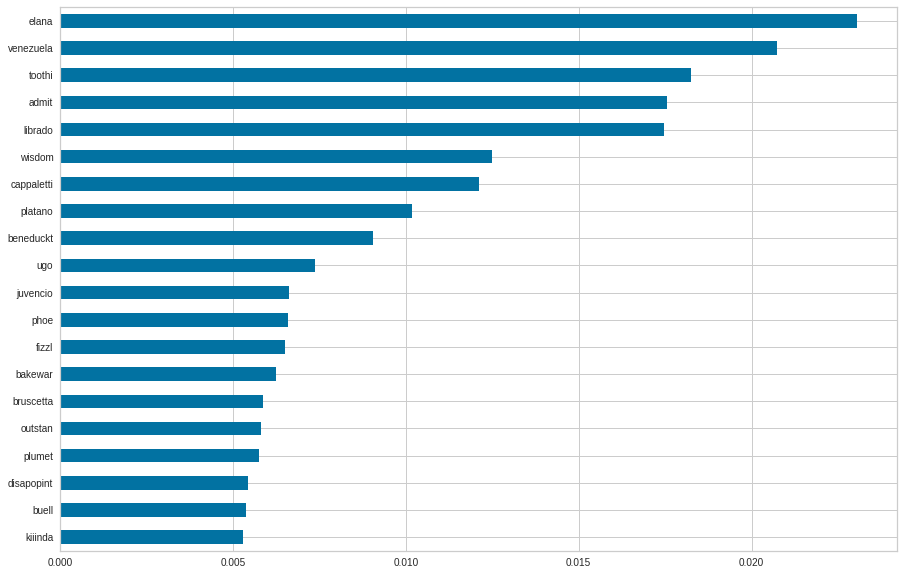

In [44]:
pd.Series(pipelineDT['clf'].feature_importances_, index = pipelineDT['bow'].vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [45]:
y_train_bow_predict = pipelineDT.predict(X_train)
y_test_bow_predict = pipelineDT.predict(X_test)

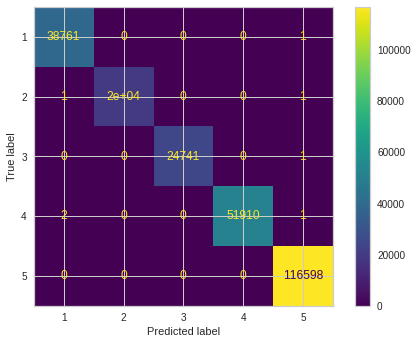

In [46]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict) #Entrenamiento

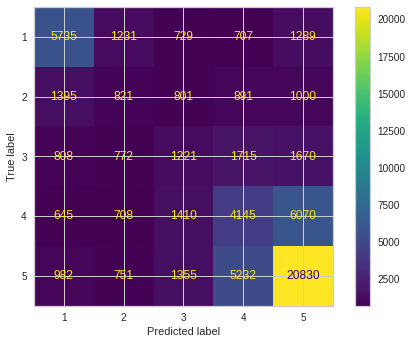

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict) #Test

In [48]:
metricsReport('Arbol de decisión', y_test, y_test_bow_predict)

Modelo Arbol de decisión
F1 Score [0.5956585  0.17865303 0.20868228 0.32297024 0.6942292 ]
F1 Score weighted 0.5144970512165631
Micro F1 Score 0.5205919285362326
Macro F1 Score 0.40003864739824485
Hamming loss 0.4794080714637674


### Bayes con TD IDF

In [49]:
pipelineB = Pipeline([
                ('bow', TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, max_df=0.6)),
                ('clf', OneVsRestClassifier(MultinomialNB())),
            ])
pipelineB.fit(X_train, y_train)
predictionsBayes = pipelineB.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


In [50]:
y_train_bow_predict = pipelineB.predict(X_train)
y_test_bow_predict = pipelineB.predict(X_test)

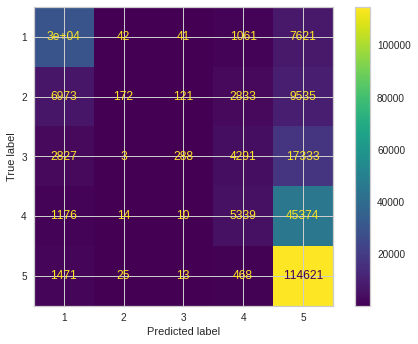

In [51]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)  #Entrenamiento

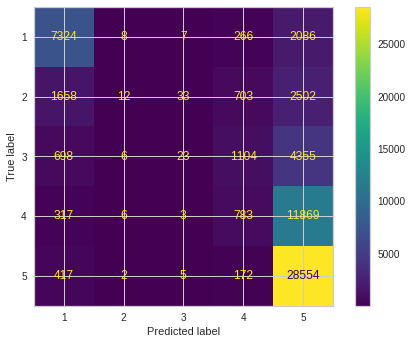

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)  #Test

In [53]:
metricsReport('Bayes', y_test, y_test_bow_predict)

Modelo Bayes
F1 Score [0.72857498 0.00485633 0.00735177 0.09783831 0.7273422 ]
F1 Score weighted 0.47051807597593304
Micro F1 Score 0.5832816746936246
Macro F1 Score 0.313192717848066
Hamming loss 0.4167183253063755


### RandomForest con TD IDF

In [54]:
pipelineRF = Pipeline([
                ('bow', TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, max_df=0.6)),
                ('clf', RandomForestClassifier(random_state = 2)),
            ])
pipelineRF.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('bow',
                 TfidfVectorizer(max_df=0.6,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 tokenizer=<function tokenizer at 0x7fa3db6c1ef0>)),
                ('clf', RandomForestClassifier(random_state=2))])

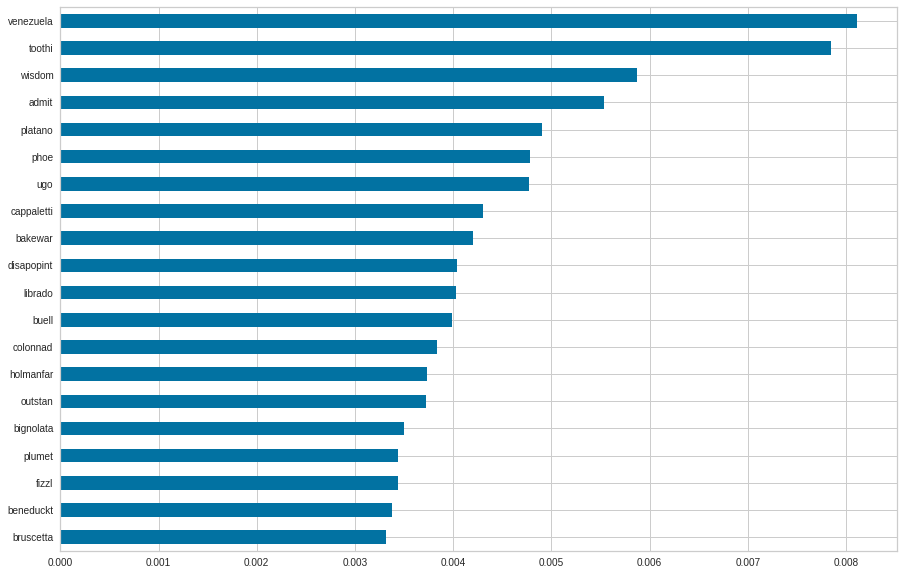

In [55]:
pd.Series(pipelineRF['clf'].feature_importances_, index = pipelineRF['bow'].vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [56]:
bow_estimators = pipelineRF['clf'].estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 714.79


In [57]:
y_train_bow_predict = pipelineRF.predict(X_train)
y_test_bow_predict = pipelineRF.predict(X_test)

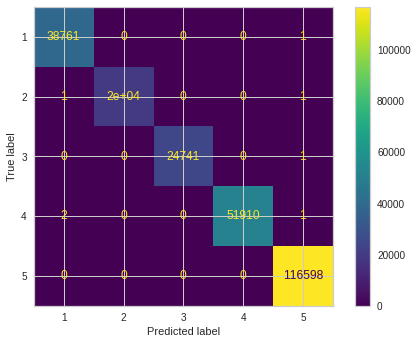

In [58]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict) #Entrenamiento

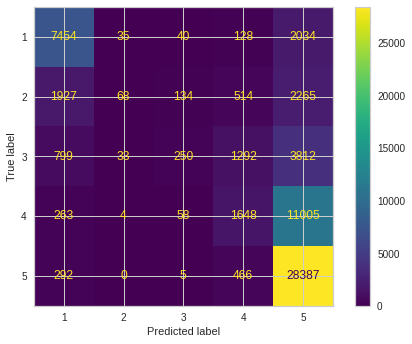

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict) #Test

In [60]:
metricsReport('RandomForest', y_test, y_test_bow_predict)

Modelo RandomForest
F1 Score [0.72985411 0.02694136 0.07492882 0.19358628 0.74066247]
F1 Score weighted 0.5050057643370017
Micro F1 Score 0.6009409819910034
Macro F1 Score 0.3531946067548983
Hamming loss 0.39905901800899657


### Arbol de decisión con TD IDF

In [61]:
pipelineDT = Pipeline([
                ('bow', TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, max_df=0.6)),
                ('clf', DecisionTreeClassifier()),
            ])
pipelineDT.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'whi', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('bow',
                 TfidfVectorizer(max_df=0.6,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 tokenizer=<function tokenizer at 0x7fa3db6c1ef0>)),
                ('clf', DecisionTreeClassifier())])

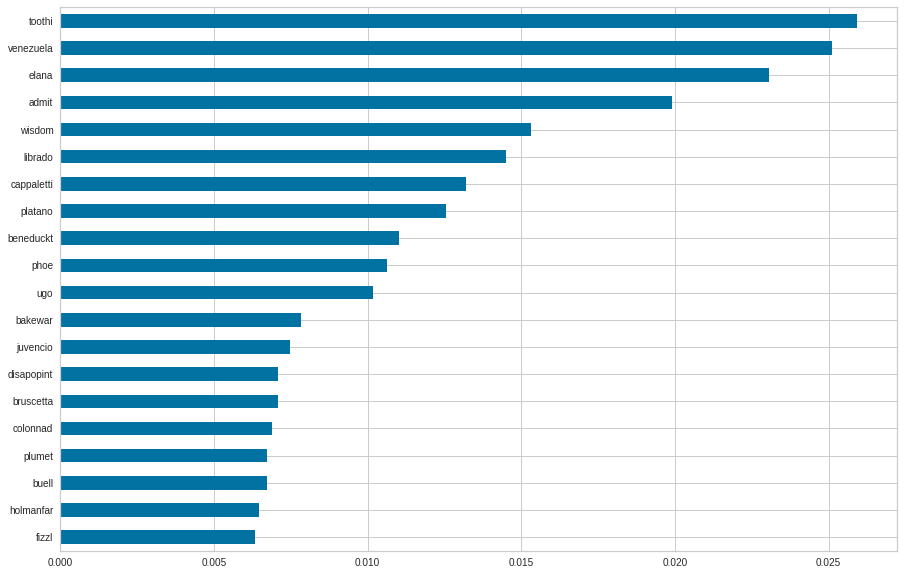

In [62]:
pd.Series(pipelineDT['clf'].feature_importances_, index = pipelineDT['bow'].vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [63]:
y_train_bow_predict = pipelineDT.predict(X_train)
y_test_bow_predict = pipelineDT.predict(X_test)

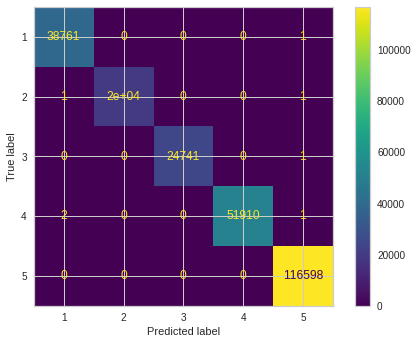

In [64]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict) #Entrenamiento

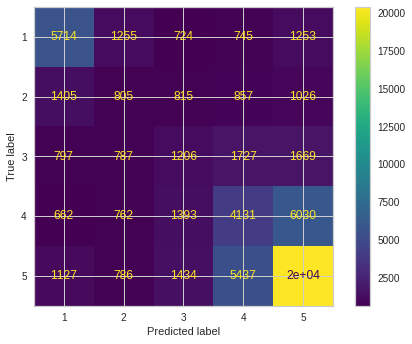

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict) #Test

In [66]:
metricsReport('Arbol de decisión', y_test, y_test_bow_predict)

Modelo Arbol de decisión
F1 Score [0.58919365 0.17306245 0.20513693 0.31930435 0.68464047]
F1 Score weighted 0.5075174394367487
Micro F1 Score 0.5121675965221815
Macro F1 Score 0.3942675689936927
Hamming loss 0.4878324034778186
